# A quickstart for Mitsuba building blocks

In [1]:
from typing import *
import numpy as np
from numpy.typing import ArrayLike
import matplotlib.pyplot as plt

import drjit as dr
import mitsuba as mi
mi.set_variant('scalar_rgb')

scene = mi.load_dict(mi.cornell_box())
ray = mi.Ray3f((0, 0, 0), (1,1,0)/np.sqrt(2))
si = scene.ray_intersect(ray)

## 3. BSDFs and their sampling: `mi.BSDF`
### `mi.BSDF` class
We can extract a BSDF object at the intersecting point as a property of the `mi.SurfaceInteraction3f` instance.

In [2]:
bsdf = si.bsdf()
print(f"{type(bsdf) = }")
assert isinstance(bsdf, mi.BSDF)
print(bsdf)

type(bsdf) = <class 'mitsuba.scalar_rgb.BSDF'>
SmoothDiffuse[
  reflectance = SRGBReflectanceSpectrum[
    value = [0.105421, 0.37798, 0.076425]
  ]
]


Important method usages:

* `bsdf.sample(ctx, si, u_1d, u_2d)` produces a random variable whose PDF is as proportional to $f_s\left(\hat\omega_i,\cdot\right)\left|\hat n \cdot \hat\omega_i\right|$ as possible. (or $f_s\left(\cdot,\hat\omega_o,\right)\left|\hat n \cdot \hat\omega_o\right|$)
* `bsdf.eval(ctx, si, wo)`$= f_s($`si.wi`$, $`wo`$)\left|\hat n \cdot \hat \omega_i\right|$
* `bsdf.pdf(ctx, si, wo)` evaluates the PDF for the sampling strategy of `bsdf.sample()`

Here, `bsdf.sample` returns not only sampled direction or BSDF value, but a 2-tuple of a `mi.BSDFSample3f` structure, which contains several information through BSDF sampling process, and a *weight* for MC integration, which is equal to:
$$
\mathtt{bsdf\_weight}=\frac{f_s\left(\hat\omega_i,\hat\omega_o\right)\left|\hat n \cdot \hat \omega_i\right|}{p\left(\hat\omega_o\mid\hat\omega_i\right)}.
$$

See the following results of the code block. Note that we do not investigate `ctx = mi.BSDFContext()` instance deeply now.

In [3]:
print("# ---------- Methods usage ----------")
ctx = mi.BSDFContext()
sampler = scene.sensors()[0].sampler()
u_1d = sampler.next_1d()
u_2d = sampler.next_2d()
bsdf_sample, bsdf_weight = bsdf.sample(ctx, si, u_1d, u_2d) # u_1d is not used NOW

print(f"{type(bsdf_sample) = }")
assert isinstance(bsdf_sample, mi.BSDFSample3f)
print(bsdf_sample, '\n')

print(f"{type(bsdf_weight) = }")
print(bsdf_weight, '\n')

bsdf_eval, bsdf_pdf = bsdf.eval_pdf(ctx, si, bsdf_sample.wo)
print(f"{type(bsdf_eval) = }")
print(bsdf_eval, '\n')

print(f"{type(bsdf_pdf) = }")
print(bsdf_pdf, '\n')

print("# ---------- Assertions ----------")
print(f"{dr.allclose(bsdf_sample.pdf, bsdf_pdf) = }")
print(f"{dr.allclose(bsdf_weight, bsdf_eval / bsdf_pdf) = }")

# ---------- Methods usage ----------
type(bsdf_sample) = <class 'mitsuba.scalar_rgb.BSDFSample3f'>
BSDFSample[
  wo = [0.800759, -0.145777, 0.580977],
  pdf = 0.184931,
  eta = 1,
  sampled_type = TODO,
  sampled_component = 0
] 

type(bsdf_weight) = <class 'mitsuba.scalar_rgb.Color3f'>
[0.10542099922895432, 0.37797999382019043, 0.07642500102519989] 

type(bsdf_eval) = <class 'mitsuba.scalar_rgb.Color3f'>
[0.01949557662010193, 0.06990009546279907, 0.014133327640593052] 

type(bsdf_pdf) = <class 'float'>
0.184930682182312 

# ---------- Assertions ----------
dr.allclose(bsdf_sample.pdf, bsdf_pdf) = True
dr.allclose(bsdf_weight, bsdf_eval / bsdf_pdf) = True


Note that `bsdf.eval_pdf()` is just a combination of `bsdf.eval()` and `bsdf.pdf()`.

In [5]:
print(f"{dr.allclose(bsdf.pdf(ctx, si, bsdf_sample.wo), bsdf_pdf) = }")
print(f"{dr.allclose(bsdf.eval(ctx, si, bsdf_sample.wo), bsdf_eval) = }")

dr.allclose(bsdf.pdf(ctx, si, bsdf_sample.wo), bsdf_pdf) = True
dr.allclose(bsdf.eval(ctx, si, bsdf_sample.wo), bsdf_eval) = True


## Dirac delta (ideal specular) cases

In [14]:
scene2 = mi.cornell_box()
scene2['green'] = {'type': 'conductor'}
scene2 = mi.load_dict(scene2)
si2 = scene2.ray_intersect(ray)
bsdf2 = si2.bsdf()
print(f"{bsdf2 = }")

bsdf2 = SmoothConductor[
  eta = UniformSpectrum[value=0.000000],
  k = UniformSpectrum[value=1.000000],
  specular_reflectance = UniformSpectrum[value=1.000000]
]


In [28]:
bs2, weight2 = bsdf2.sample(ctx, si2, 0, [0, 0])
print(f"{bs2 = }")
print(f"{weight2 = }")
print(f"{mi.has_flag(bs2.sampled_type, mi.BSDFFlags.Delta) = }")

bs2 = BSDFSample[
  wo = [-3.09086e-08, 0.707107, 0.707107],
  pdf = 1,
  eta = 1,
  sampled_type = TODO,
  sampled_component = 0
]
weight2 = [1.0, 1.0, 1.0]
mi.has_flag(bs2.sampled_type, mi.BSDFFlags.Delta) = True


Note that equality comparison `==` is no more reliable for floating-point real numbers. Once `bs2: mi.BSDFSample3f` is sampled from `bsdf2: mi.BSDF` and `si2: mi.SurfaceInteraction3f`, you should not evaluate `bsdf2.eval(ctx, si2, bs2)` again. Please uses `bs2` and `weight2`.

In [34]:
bsdf2.eval(ctx, si2, bs2.wo)

[0.0, 0.0, 0.0]

In [23]:
bsdf2.sample(ctx, si2, 0, [1, 1])

(BSDFSample[
   wo = [-3.09086e-08, 0.707107, 0.707107],
   pdf = 1,
   eta = 1,
   sampled_type = TODO,
   sampled_component = 0
 ],
 [1.0, 1.0, 1.0])

### Spawn ray
Once sampled refelcted (or refracted) directions for given `bsdf` at `si`, we should usually construct a new ray object with origin `si.p` and direction `bsdf_sample.wo`. In this case, using the method `mi.SurfaceInteraction3f.spawn_ray()` is more recommended than directly calling the constructor `mi.Ray3f`.

In [6]:
ray_spawn = si.spawn_ray(si.to_world(bsdf_sample.wo))
print(ray_spawn)
print(si.p)

Ray3f[
  o = [0.999821, 1, -7.8136e-12],
  d = [-0.580977, -0.145777, 0.800759],
  maxt = 3.40282e+38,
  time = 0,
]
[1.0, 0.9999999403953552, 2.605401771470185e-15]


Here, we observe that `ray_spawn.o` has a tiny offset from `si.p`. It comes from an issue of numerical computation of floating-point numbers. Refer to the following material for details.

Pharr, Matt, Wenzel Jakob, and Greg Humphreys. Physically based rendering: From theory to implementation. MIT Press, 2023.
3 Shapes - 3.9 Managing Rounding Error
https://www.pbr-book.org/3ed-2018/Shapes/Managing_Rounding_Error

In [7]:
print(mi.Ray3f(si.p, si.to_world(bsdf_sample.wo)))

Ray3f[
  o = [1, 1, 2.6054e-15],
  d = [-0.580977, -0.145777, 0.800759],
  maxt = 3.40282e+38,
  time = 0,
]


### Visualize BSDF sapmling
Try the following visualization of BSDF sampling. The single red dot indicates `wi` and many blue dots indicate sampled `wo`'s. The middle plot visualizes projection of sampled direction on $xy$ plane. In the following diffuse BRDF example, the BSDF is $f_s=\frac{\rho}{\pi}$. Observe that the sampled points are uniformly distributed not in the left plot, but in the middle plot. It indicates the sampling PDF is proportional to $f_s\cdot \cos\theta$, not just $f_s$.

In the right plot, we observe that the *weight* ($f_s\cdot \cos \theta/p$) value returned by `bsdf.sample()` records constant values.

In [8]:
def bsdf_sample_statistics(N: int, si: mi.SurfaceInteraction3f, sampler: mi.Sampler
                          ) -> Tuple[np.ndarray, np.ndarray]:
    wo = np.zeros((N, 3))
    weights = np.zeros((N, 3))
    for i in range(N):
        bsdf_sample, bsdf_weight = si.bsdf().sample(ctx, si, sampler.next_1d(), sampler.next_2d())
        wo[i, :] = bsdf_sample.wo.numpy()
        weights[i, :] = bsdf_weight.numpy()
    return wo, weights

N = 10000
wo, weights = bsdf_sample_statistics(N, si, sampler)

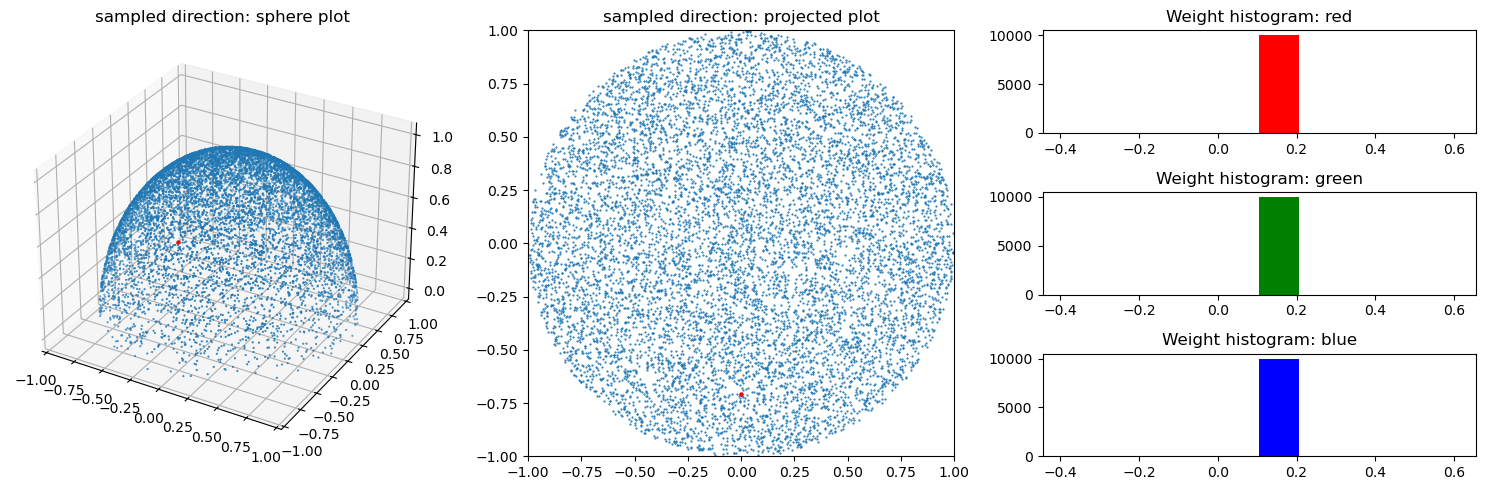

In [9]:
def plot_bsdf_samples(wos: ArrayLike, # [N, 3],
                      weights: ArrayLike, #[N, 3]
                      wi: mi.Vector3f # [3]
                     ):
    # wos = wos / np.linalg.norm(wos, axis=1, keepdims=True)
    wi = np.array(wi)
    # wi = np.array(wi) / np.linalg.norm(wi)

    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(1, 3, 1, projection='3d')
    ax.scatter(*(wos.T), s=0.3)
    ax.scatter(*(wi*1.05), s=5.0, c='red')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_title("sampled direction: sphere plot")

    ax = fig.add_subplot(1, 3, 2, aspect='equal')
    ax.scatter(*(wos.T[:2,:]), s=0.3);
    ax.scatter(*wi[:2], s=5.0, c='red')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_title("sampled direction: projected plot")

    for i,col in zip(range(3), ['red', 'green', 'blue']):
        ax = fig.add_subplot(3, 3, 3*i+3)
        ax.hist(weights[:,0], color=col)
        ax.set_title("Weight histogram: "+col)

    fig.tight_layout()
plot_bsdf_samples(wo, weights, si.wi)

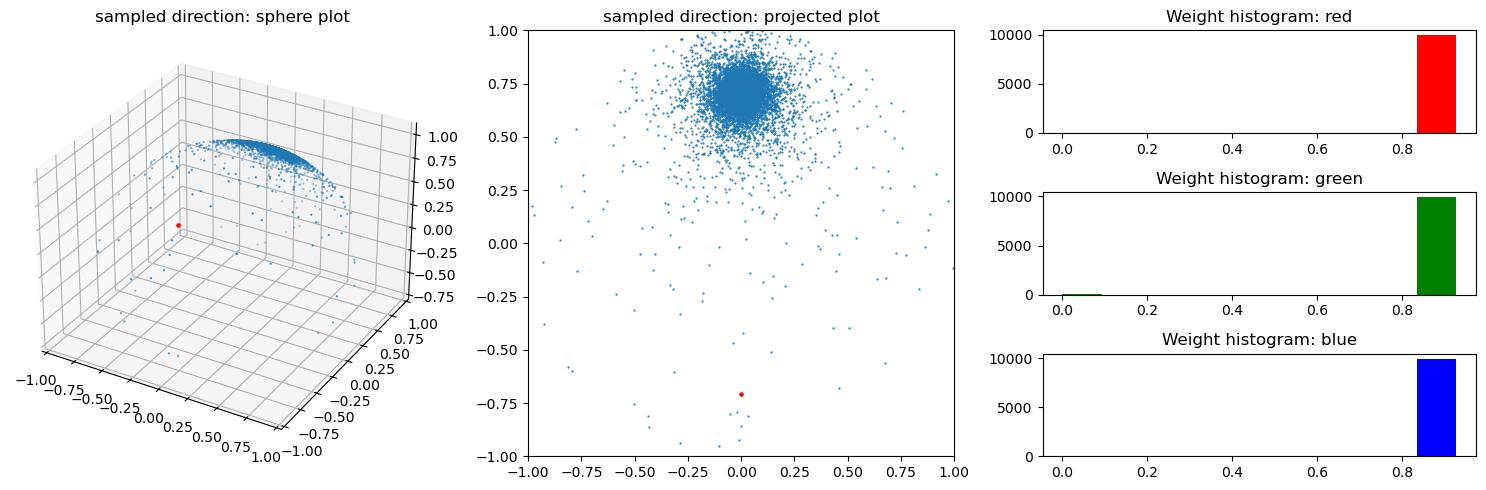

In [10]:
scene_dict = mi.cornell_box()
for key in ['white', 'green', 'red']:
    scene_dict[key] = {'type': 'roughconductor',
                       'material': 'Al',
                       'distribution': 'ggx',
                       'alpha': 0.05}
scene2 = mi.load_dict(scene_dict)

si2 = scene2.ray_intersect(ray)
wo, weights = bsdf_sample_statistics(N, si2, sampler)
plot_bsdf_samples(wo, weights, si2.wi)

However, for a `roughplastic` material, we observe that the *weight* is not constant. Note that making a sampling strategy be proportional to $f_s \cdot\cos\theta$ is desirable if possible, but not strictly mandatory. If the BSDF function is too complicate, a similar PDF is okay.

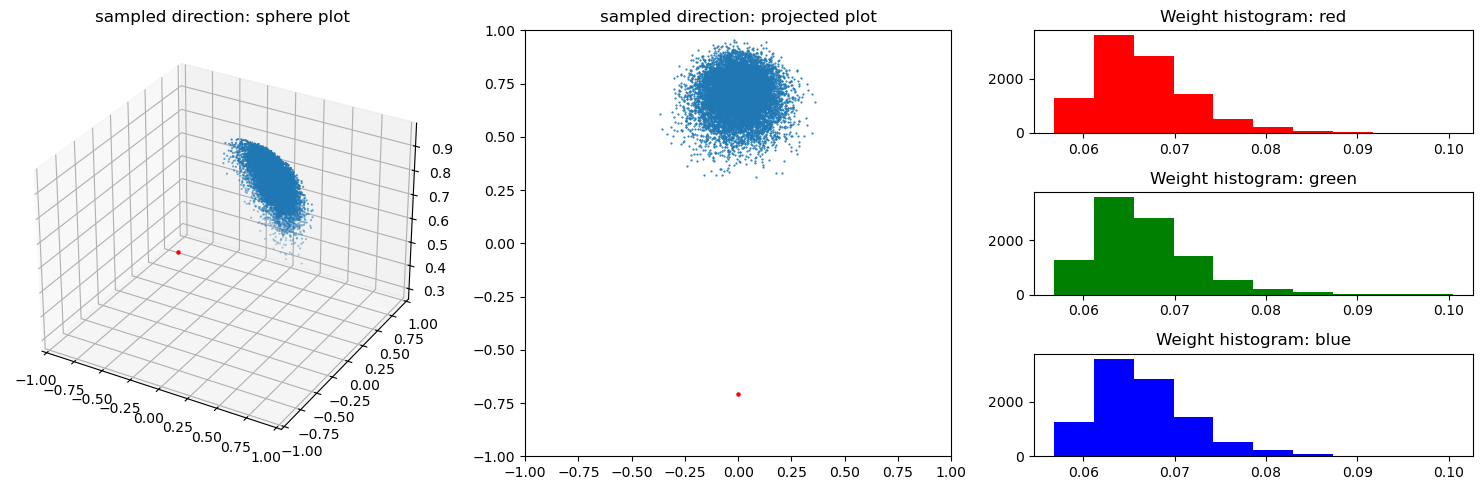

In [11]:
scene_dict = mi.cornell_box()
for key in ['white', 'green', 'red']:
    scene_dict[key] = {'type': 'roughplastic',
                       'distribution': 'beckmann',
                       'int_ior': 1.61,
                       'diffuse_reflectance': {
                            'type': 'rgb',
                            'value': 0
                       }}
scene3 = mi.load_dict(scene_dict)

si3 = scene3.ray_intersect(ray)
wo, weights = bsdf_sample_statistics(N, si3, sampler)
plot_bsdf_samples(wo, weights, si3.wi)